**Description**: Tries to answer [my answer on
stats.stackexchange.com](https://stats.stackexchange.com/q/611877/337906). This
meta-analysis suggests that pretraining on test set features (no labels) can be okay.

**Estimated runtime**: ~1 hour (Multi-core isn't working on my machine. Set
`cores=4` in the `model.fit` call if it works for you.)

Note: I'm still learning how to do this type of analysis.

In [1]:
import os
from typing import Literal

import arviz as az
import bambi as bmb
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sns.set_theme(style="darkgrid")

In [3]:
model: Literal["bert", "gpt2"] = "bert"
num_test: int = 500

# Load data

In [4]:
ACCURACIES_DIR = os.path.join("accuracies_from_paper", str(num_test), model)

_dfs = []
for dataset in sorted(os.listdir(ACCURACIES_DIR)):
    _df = pd.read_csv(os.path.join(ACCURACIES_DIR, dataset, "accuracies.csv"))
    _df["dataset"] = dataset
    _dfs.append(_df)
accuracy_df = pd.concat(_dfs)
accuracy_df = accuracy_df[["dataset", "base", "extra", "test"]]

In [5]:
num_correct_df = (accuracy_df.copy()[["base", "extra", "test"]] * num_test).astype(
    int, errors="raise"
)
num_correct_df["dataset"] = accuracy_df["dataset"].copy()
num_correct_df = num_correct_df[["dataset", "base", "extra", "test"]]
num_correct_df["pair"] = range(len(num_correct_df))
num_correct_df

,dataset,base,extra,test,pair
0,ag_news,403,432,430,0
1,ag_news,309,408,427,1
2,ag_news,340,424,433,2
3,ag_news,333,436,422,3
4,ag_news,285,419,405,4
...,...,...,...,...,...
15,yelp_review_full,104,132,182,395
16,yelp_review_full,119,133,181,396
17,yelp_review_full,140,129,166,397
18,yelp_review_full,150,148,163,398


# Model

A multilevel model is fit:

$$
\begin{align*}
Y_{ijk} \sim \text{Poisson}(\lambda_{ijk}) && \text{number of correct predictions} \\
\log(\lambda_{ijk}) = \mu + U_i + V_{ij} + \beta x_{ijk} && \text{additive effects} \\
\mu \sim \text{Normal}(0, 3.5355) && \text{prior for intercept} \\
U_i \sim \text{Normal}(0, \sigma_{D}) && \text{effect of dataset} \\
V_{ij} \sim \text{Normal}(0, \sigma_{V}) && \text{(nested) effect of dataset subsample (AKA pair)} \\
\beta \sim \text{Normal}(0, 5) && \text{prior for main effect} \\
\sigma_{D}, \sigma_{V} \sim \text{HalfNormal}(0, 3.5355) && \text{prior for standard deviations}.
\end{align*}
$$

$i = 1, 2, \dots, 14$ for the dataset.

$j = 1, 2, \dots, 50$ for the subsample of dataset $i$.

$k = 1, 2$ for control and treatment.

$x_{ijk} = 0$ if $k = 1$ else it's $1$. We'll perform inference on $\beta$ via MCMC.

# Analysis code

In [6]:
def _violin_plot(
    accuracy_df: pd.DataFrame,
    paired_diff_column: str,
    title: str,
    color,
    **ylabel_kwargs
):
    _, axes = plt.subplots(figsize=(16, 2))
    axes: plt.Axes
    sns.violinplot(
        data=accuracy_df, x="dataset", y=paired_diff_column, ax=axes, color=color
    )
    plt.axhline(0, linestyle="dashed", color="gray")
    axes.set_title(title)
    axes.yaxis.grid(True)
    axes.set_xlabel("Text classification dataset")
    axes.set_ylabel(**ylabel_kwargs)
    plt.xticks(rotation=45, ha="right")
    plt.show()

In [7]:
def eda(
    accuracy_df: pd.DataFrame,
    control_column: str,
    treatment_column: str,
    title: str,
    color,
    **ylabel_kwargs,
):
    accuracy_df = accuracy_df.copy()
    paired_diff_column = f"{treatment_column} - {control_column}"
    accuracy_df[paired_diff_column] = (
        accuracy_df[treatment_column] - accuracy_df[control_column]
    )
    _violin_plot(accuracy_df, paired_diff_column, title, color, **ylabel_kwargs)
    # fmt: off
    summary = (
        accuracy_df
        .groupby("dataset")
        [paired_diff_column]
        .describe()
        [["mean", "std"]]
    )
    # fmt: on
    print(summary.mean())
    return summary.round(3)

In [8]:
def stat_model(
    num_correct_df: pd.DataFrame, control_column: str, treatment_column: str
) -> tuple[bmb.Model, az.InferenceData]:
    df = (
        num_correct_df[["pair", "dataset", control_column, treatment_column]]
        .melt(["pair", "dataset"], var_name="method", value_name="num_correct")
        .sort_values("pair")
        .reset_index(drop=True)
    )
    # Pairs/subsamples were formed from the dataset. So it's nested, not crossed.
    # Technically, crossed notation—(1|dataset) + (1|pair)—would still result in a
    # nested inference b/c pair is uniquely coded
    model = bmb.Model(
        "num_correct ~ method + (1|dataset/pair)", family="poisson", data=df
    )
    inference_method = "mcmc" if not torch.cuda.is_available() else "nuts_numpyro"
    fit_summary: az.InferenceData = model.fit(
        inference_method=inference_method, chains=4, random_seed=123, cores=1
    )
    az_summary: pd.DataFrame = az.summary(fit_summary)
    display(
        az_summary.loc[
            [index_name for index_name in az_summary.index if "method" in index_name]
        ]
    )

    az.plot_trace(fit_summary, compact=False, var_names="method", filter_vars="like")
    return model, fit_summary

In [9]:
model_name = "BERT" if model == "bert" else "GPT-2"

# Does pretraining help?

This is our control.

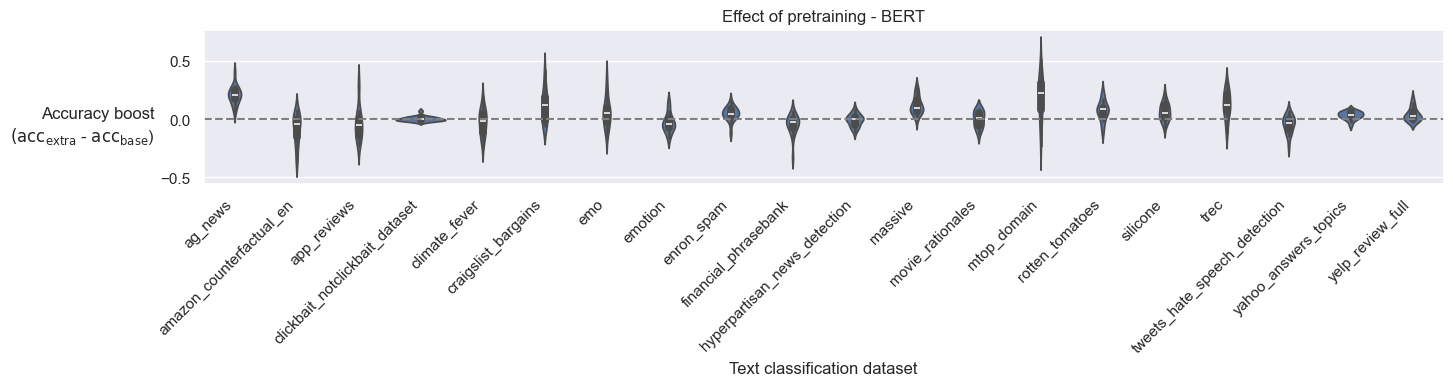

mean    0.040740
std     0.089722
dtype: float64


,mean,std
dataset,,
ag_news,0.208,0.076
amazon_counterfactual_en,-0.086,0.128
app_reviews,-0.036,0.141
clickbait_notclickbait_dataset,0.004,0.021
climate_fever,-0.024,0.110
craigslist_bargains,0.117,0.138
emo,0.059,0.126
emotion,-0.032,0.080
enron_spam,0.049,0.060


In [10]:
eda(
    accuracy_df,
    control_column="base",
    treatment_column="extra",
    title=f"Effect of pretraining - {model_name}",
    color=None,
    ylabel=(
        "Accuracy boost\n$(\\text{acc}_\\text{extra}$ - $\\text{acc}_\\text{base}$)"
    ),
    rotation="horizontal",
    ha="right",
    va="top",
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, method, 1|dataset_sigma, 1|dataset_offset, 1|dataset:pair_sigma, 1|dataset:pair_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2436 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[extra],0.08,0.005,0.072,0.089,0.0,0.0,9105.0,2592.0,1.0


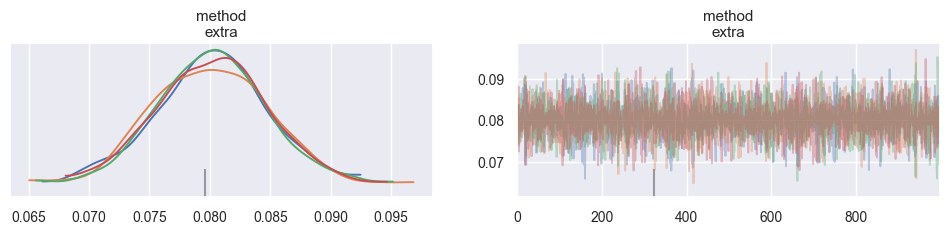

In [11]:
model_control, summary_control = stat_model(
    num_correct_df, control_column="base", treatment_column="extra"
)

In [12]:
print(model_control)

       Formula: num_correct ~ method + (1|dataset/pair)
        Family: poisson
          Link: mu = log
  Observations: 800
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 3.5355)
            method ~ Normal(mu: 0.0, sigma: 5.0)
        
        Group-level effects
            1|dataset ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.5355))
            1|dataset:pair ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.5355))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()


Solid evidence that pretraining helps. There's an effect to detect.

# Does pretraining on test cause bias?

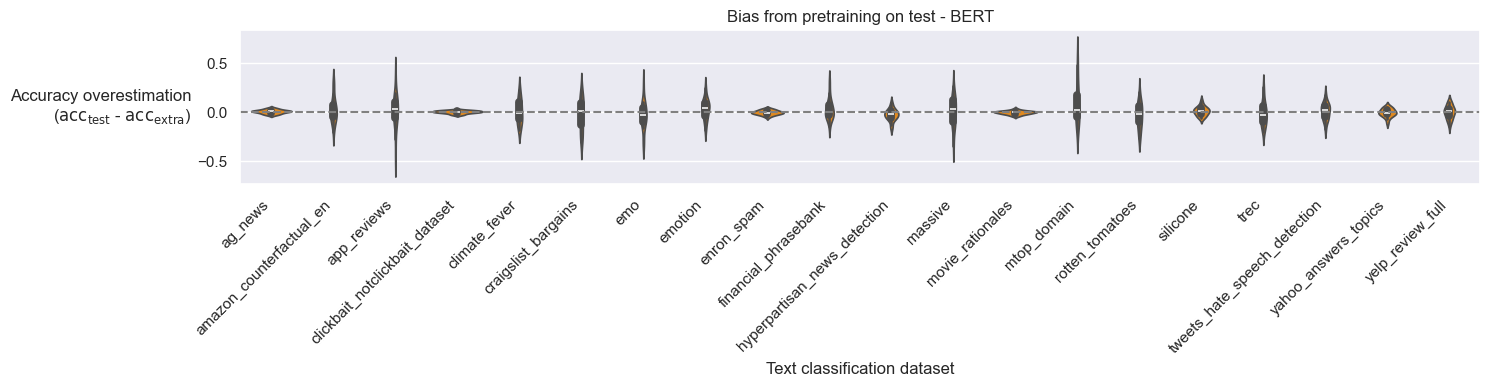

mean    0.001700
std     0.094401
dtype: float64


,mean,std
dataset,,
ag_news,0.005,0.019
amazon_counterfactual_en,0.022,0.127
app_reviews,0.007,0.176
clickbait_notclickbait_dataset,0.001,0.015
climate_fever,0.002,0.122
craigslist_bargains,-0.024,0.161
emo,-0.035,0.138
emotion,0.033,0.101
enron_spam,-0.005,0.023


In [13]:
eda(
    accuracy_df,
    control_column="extra",
    treatment_column="test",
    title=f"Bias from pretraining on test - {model_name}",
    color="darkorange",
    ylabel=(
        "Accuracy overestimation\n"
        "($\\text{acc}_\\text{test}$ - $\\text{acc}_\\text{extra}$)"
    ),
    rotation="horizontal",
    ha="right",
    va="center",
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, method, 1|dataset_sigma, 1|dataset_offset, 1|dataset:pair_sigma, 1|dataset:pair_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1005 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[test],0.003,0.004,-0.005,0.011,0.0,0.0,6855.0,2847.0,1.0


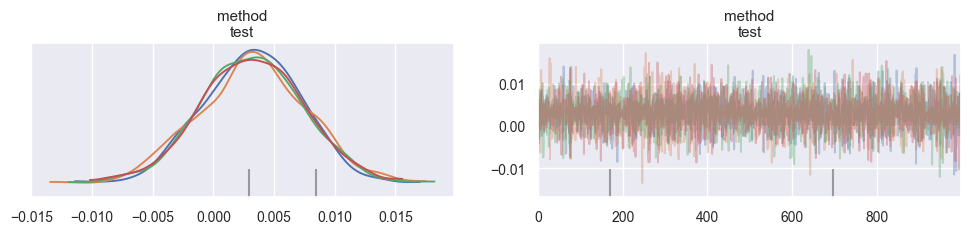

In [14]:
model_bias, summary_bias = stat_model(
    num_correct_df, control_column="extra", treatment_column="test"
)

In [15]:
print(model_bias)

       Formula: num_correct ~ method + (1|dataset/pair)
        Family: poisson
          Link: mu = log
  Observations: 800
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 3.5355)
            method ~ Normal(mu: 0.0, sigma: 5.0)
        
        Group-level effects
            1|dataset ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.5355))
            1|dataset:pair ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.5355))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()


BERT (500): Not good evidence of a bias: $e^{0.003} - 1 \times 100\% \approx 0.3\%$
relative increase in accuracy.

BERT (200): There's evidence of a tiny bias (>90% of the posterior mass is on the right
side): $e^{0.007} - 1 \times 100\% \approx 0.7\%$ relative increase in accuracy.

GPT-2 (500): todo

GPT-2 (200): Not good evidence of a bias: $e^{0.003} - 1 \times 100\% \approx 0.3\%$
relative increase in accuracy.

Fun fact: $e^x - 1 \approx x$ for $x \in (-0.01, 0.01)$. Makes it easy to interpret
Poisson models.

I'll re-analyze the combined data, stratifying by model.